In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import re

# demos=pd.read_csv('demographics.csv')
# demos.drop(demos[demos['Season']==2016].index, inplace=True)
# demos.drop(columns='Unnamed: 0', inplace=True, axis=1)
# demos.info()


I notice that for 2016, the column contain the names of positions instead of numbers. I am going to use height16edits.ipynb to make changes to that year and re-insert the data.

The formatting needed to combine the datasets is done, so we can remove the code from our runs.

In [2]:
# sixteen=pd.read_csv('sixteen.csv')
# sixteen=sixteen.drop(columns='Unnamed: 0',axis=1)
# print(demos.columns)
# print(sixteen.columns)

In [3]:

# cols_sixteen = set(sixteen.columns)
# cols_demos = set(demos.columns)

# only_in_sixteen = cols_sixteen - cols_demos
# only_in_demos = cols_demos - cols_sixteen

# print("Columns in sixteen but not in demos:", only_in_sixteen)
# print("Columns in demos but not in sixteen:", only_in_demos)
# demos=demos.drop(columns=only_in_demos, axis=1)

In [4]:
# demos.head()

In [5]:
# demofinal=pd.merge(sixteen, demos, on=['Season','TeamName','Size','SizeRank','Hgt5','Hgt5Rank','Hgt4','Hgt4Rank','Hgt3','Hgt3Rank','Hgt2','Hgt2Rank','Hgt1','Hgt1Rank','HgtEff','HgtEffRank','Exp','ExpRank','Bench','BenchRank','Pts5','Pts5Rank','Pts4','Pts4Rank','Pts3','Pts3Rank','Pts2','Pts2Rank','Pts1','Pts1Rank','OR5','OR5Rank','OR4','OR4Rank','OR3','OR3Rank','OR2','OR2Rank','OR1','OR1Rank','DR5','DR5Rank','DR4','DR4Rank','DR3','DR3Rank','DR2','DR2Rank','DR1','DR1Rank'], how='outer')

In [6]:
# demofinal.to_csv('finalheights.csv')

In [7]:
demofinal=pd.read_csv('finalheights.csv')

In [8]:
demofinal=demofinal[demofinal.columns.drop(list(demofinal.filter(regex='Rank')))]

In [9]:
demofinal.head()

,Unnamed: 0,Season,TeamName,Size,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,HgtEff,...,OR5,OR4,OR3,OR2,OR1,DR5,DR4,DR3,DR2,DR1
0,0,2007,Air Force,77.00,-0.69,-0.06,1.07,1.32,2.47,-0.75,...,21.74,25.11,18.12,24.00,11.03,23.29,24.96,18.92,14.67,18.17
1,1,2007,Akron,75.76,-1.52,0.47,-2.08,-1.85,0.47,-1.05,...,27.05,28.40,31.45,7.71,5.38,22.97,24.52,28.40,12.05,12.05
2,2,2007,Alabama,77.65,0.52,0.26,2.07,1.39,0.31,0.78,...,23.41,37.60,22.21,11.41,5.36,32.71,29.21,17.16,12.68,8.24
3,3,2007,Alabama A&M,77.01,1.75,-1.17,0.07,1.15,1.47,0.58,...,25.17,29.00,11.99,15.91,17.92,34.37,21.22,13.70,15.21,15.49
4,4,2007,Alabama St.,76.28,-1.16,-0.26,1.07,1.20,-1.53,-1.42,...,28.95,30.34,17.95,17.56,5.20,29.66,24.80,14.84,13.82,16.88


In [10]:
demofinal.drop(columns='Unnamed: 0')

,Season,TeamName,Size,Hgt5,Hgt4,Hgt3,Hgt2,Hgt1,HgtEff,Exp,...,OR5,OR4,OR3,OR2,OR1,DR5,DR4,DR3,DR2,DR1
0,2007,Air Force,77.00,-0.69,-0.06,1.07,1.32,2.47,-0.75,2.61000,...,21.74,25.11,18.12,24.00,11.03,23.29,24.96,18.92,14.67,18.17
1,2007,Akron,75.76,-1.52,0.47,-2.08,-1.85,0.47,-1.05,2.09000,...,27.05,28.40,31.45,7.71,5.38,22.97,24.52,28.40,12.05,12.05
2,2007,Alabama,77.65,0.52,0.26,2.07,1.39,0.31,0.78,1.41000,...,23.41,37.60,22.21,11.41,5.36,32.71,29.21,17.16,12.68,8.24
3,2007,Alabama A&M,77.01,1.75,-1.17,0.07,1.15,1.47,0.58,0.77000,...,25.17,29.00,11.99,15.91,17.92,34.37,21.22,13.70,15.21,15.49
4,2007,Alabama St.,76.28,-1.16,-0.26,1.07,1.20,-1.53,-1.42,1.91000,...,28.95,30.34,17.95,17.56,5.20,29.66,24.80,14.84,13.82,16.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,2025,Wright St.,76.63,-1.39,-0.73,0.26,-0.52,-0.49,-1.06,2.00172,...,26.22,41.45,20.16,5.34,6.81,28.67,25.95,19.71,13.53,12.12
6666,2025,Wyoming,77.75,0.36,0.22,0.89,0.39,0.88,0.29,1.80689,...,36.19,33.38,16.20,10.61,3.59,23.34,19.66,27.31,18.98,10.65
6667,2025,Xavier,77.30,0.09,0.91,0.24,0.04,-0.80,0.50,3.53178,...,36.35,29.24,19.17,8.25,6.99,27.81,22.29,23.11,14.70,12.09
6668,2025,Yale,77.74,-0.73,-0.58,0.89,1.64,1.44,-0.65,1.66222,...,34.66,27.31,22.18,6.20,9.59,16.18,24.71,20.32,17.02,21.76


In [11]:
demofinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6670 entries, 0 to 6669
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6670 non-null   int64  
 1   Season      6670 non-null   int64  
 2   TeamName    6670 non-null   object 
 3   Size        6670 non-null   float64
 4   Hgt5        6670 non-null   float64
 5   Hgt4        6670 non-null   float64
 6   Hgt3        6670 non-null   float64
 7   Hgt2        6670 non-null   float64
 8   Hgt1        6670 non-null   float64
 9   HgtEff      6670 non-null   float64
 10  Exp         6670 non-null   float64
 11  Bench       6670 non-null   float64
 12  Pts5        6670 non-null   float64
 13  Pts4        6670 non-null   float64
 14  Pts3        6670 non-null   float64
 15  Pts2        6670 non-null   float64
 16  Pts1        6670 non-null   float64
 17  OR5         6670 non-null   float64
 18  OR4         6670 non-null   float64
 19  OR3         6670 non-null  

In [12]:
demofinal=demofinal[demofinal['Size'] !=0]
demofinal.drop(columns=['Unnamed: 0'], inplace=True, axis=1)

In [13]:
# demofinal.to_csv('bigtime.csv')

We have 

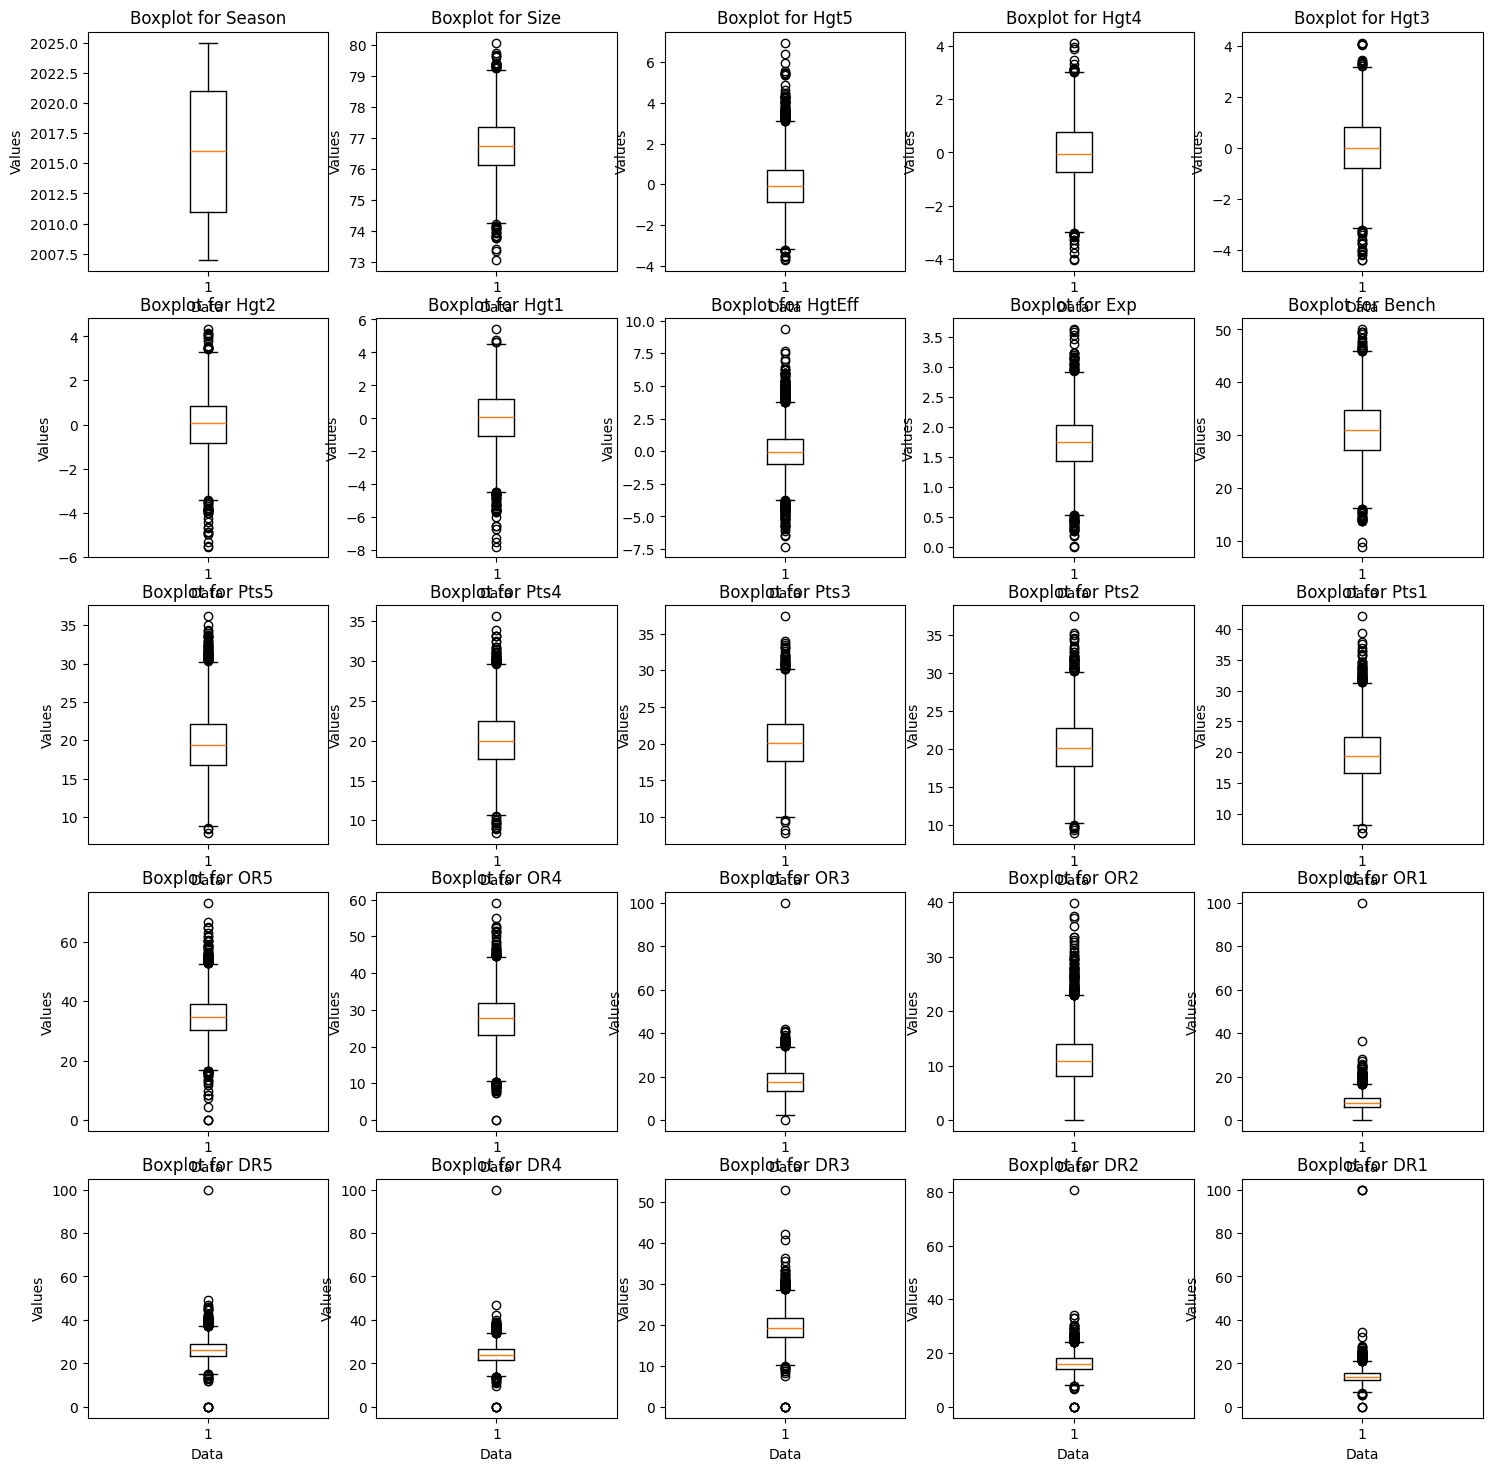

In [14]:
numerical=demofinal.select_dtypes(exclude='object')
fig, ax=plt.subplots(nrows=5, ncols=5, figsize=(18,18))
ax=ax.flatten()
for i,col in enumerate(numerical.columns):
    ax[i].boxplot(numerical[col])
    ax[i].set_title(f'Boxplot for {col}')
    ax[i].set_xlabel('Data')
    ax[i].set_ylabel('Values')
plt.show()

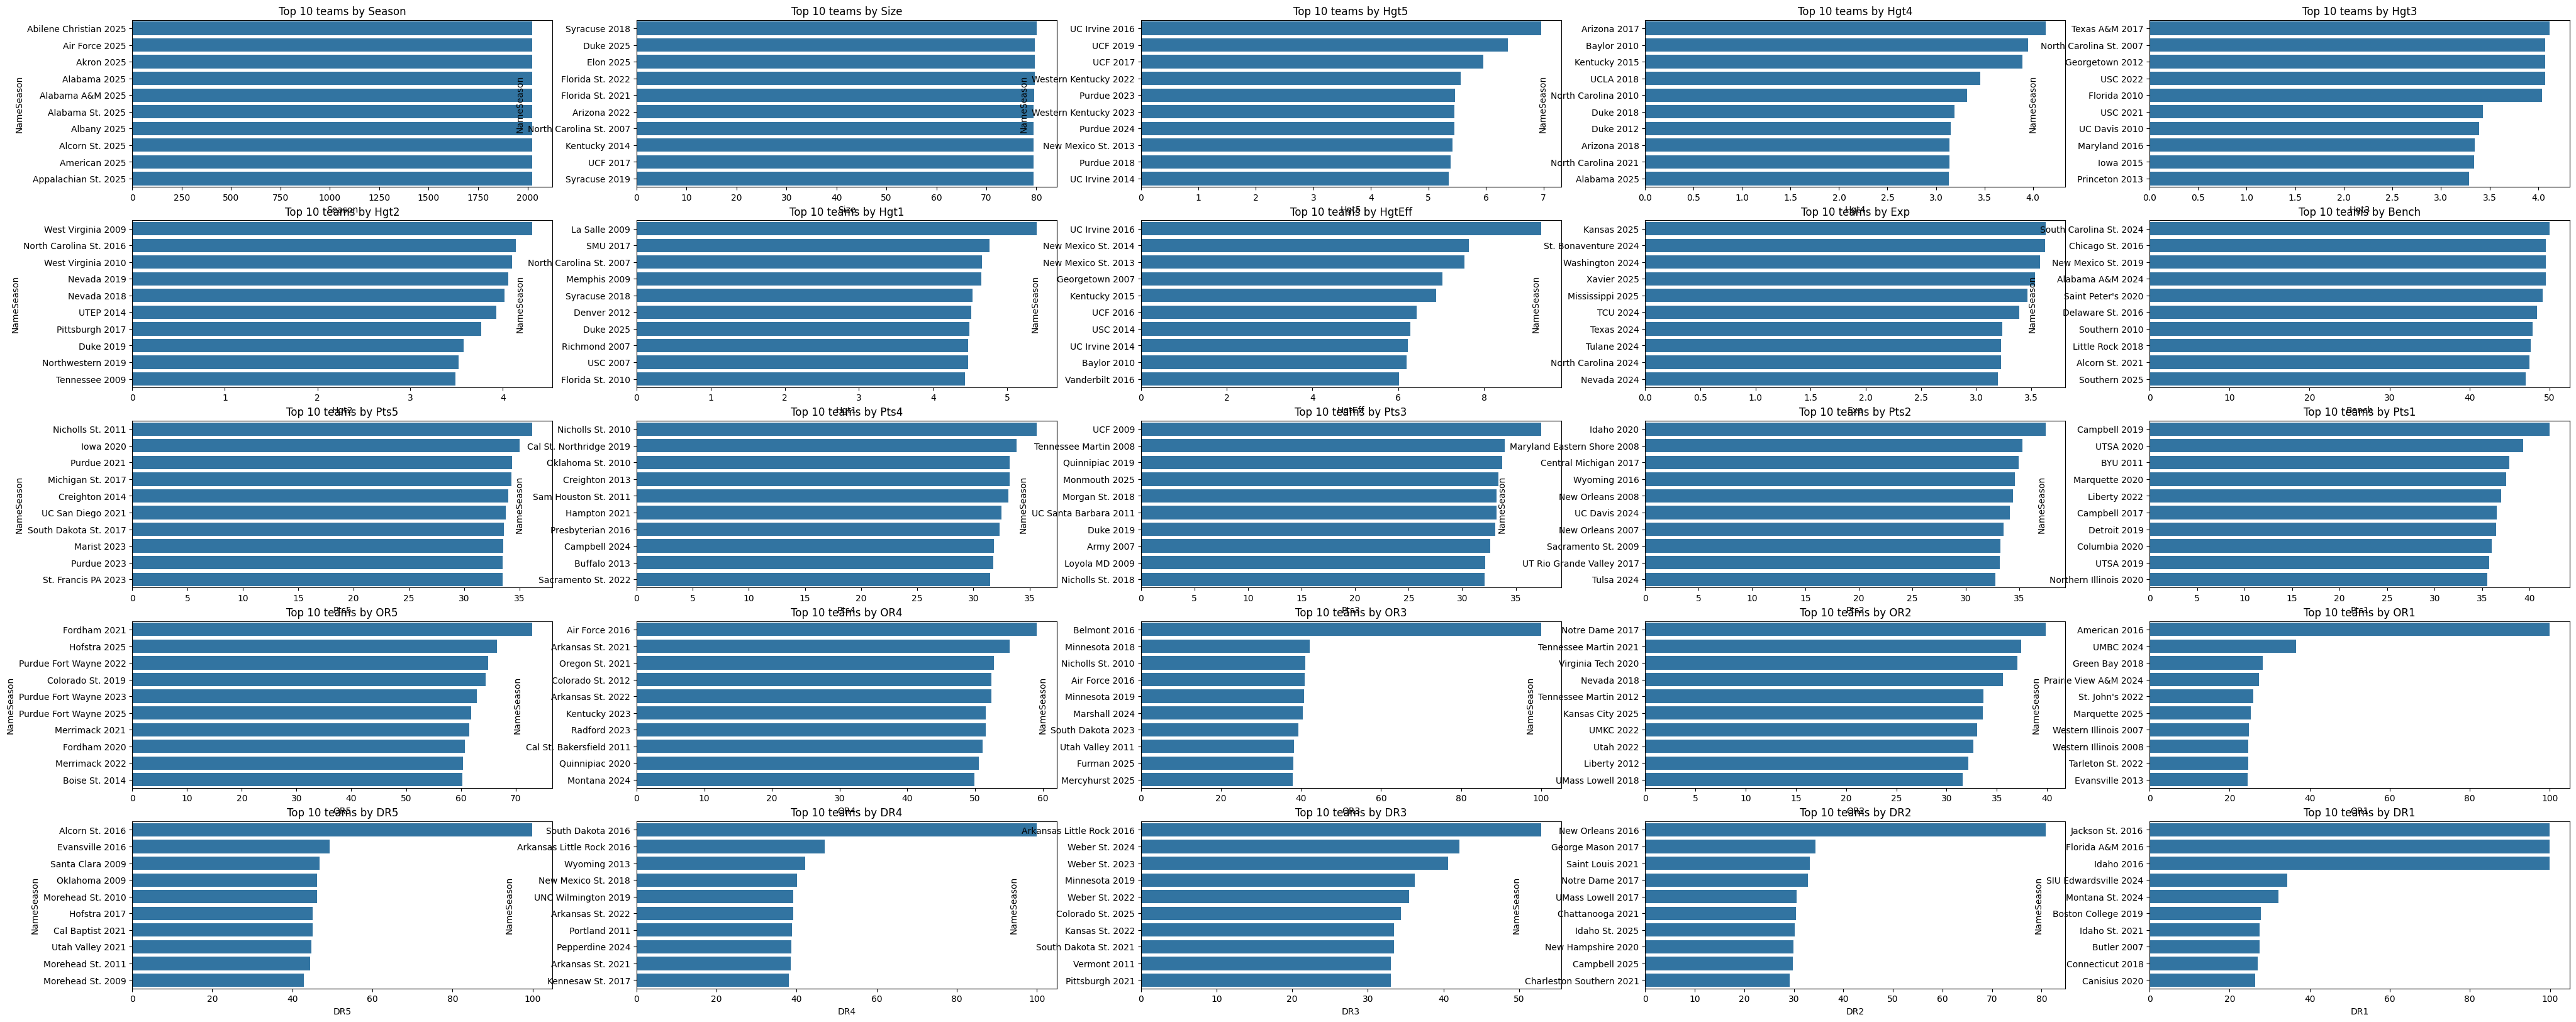

In [15]:
fig, ax=plt.subplots(nrows=5, ncols=5, figsize=(50,20))
ax=ax.flatten()
for i, col in enumerate(numerical.columns):
    top_10=demofinal.nlargest(10, col)
    for index,row in top_10.iterrows():
        top_10.at[index, 'NameSeason']= f"{row['TeamName']} {row['Season']}"
    sns.barplot(x=top_10[col],y=top_10['NameSeason'], ax=ax[i])
    ax[i].set_title(f'Top 10 teams by {col}')
    ax[i].set_xlabel(f'{col}')
plt.show()


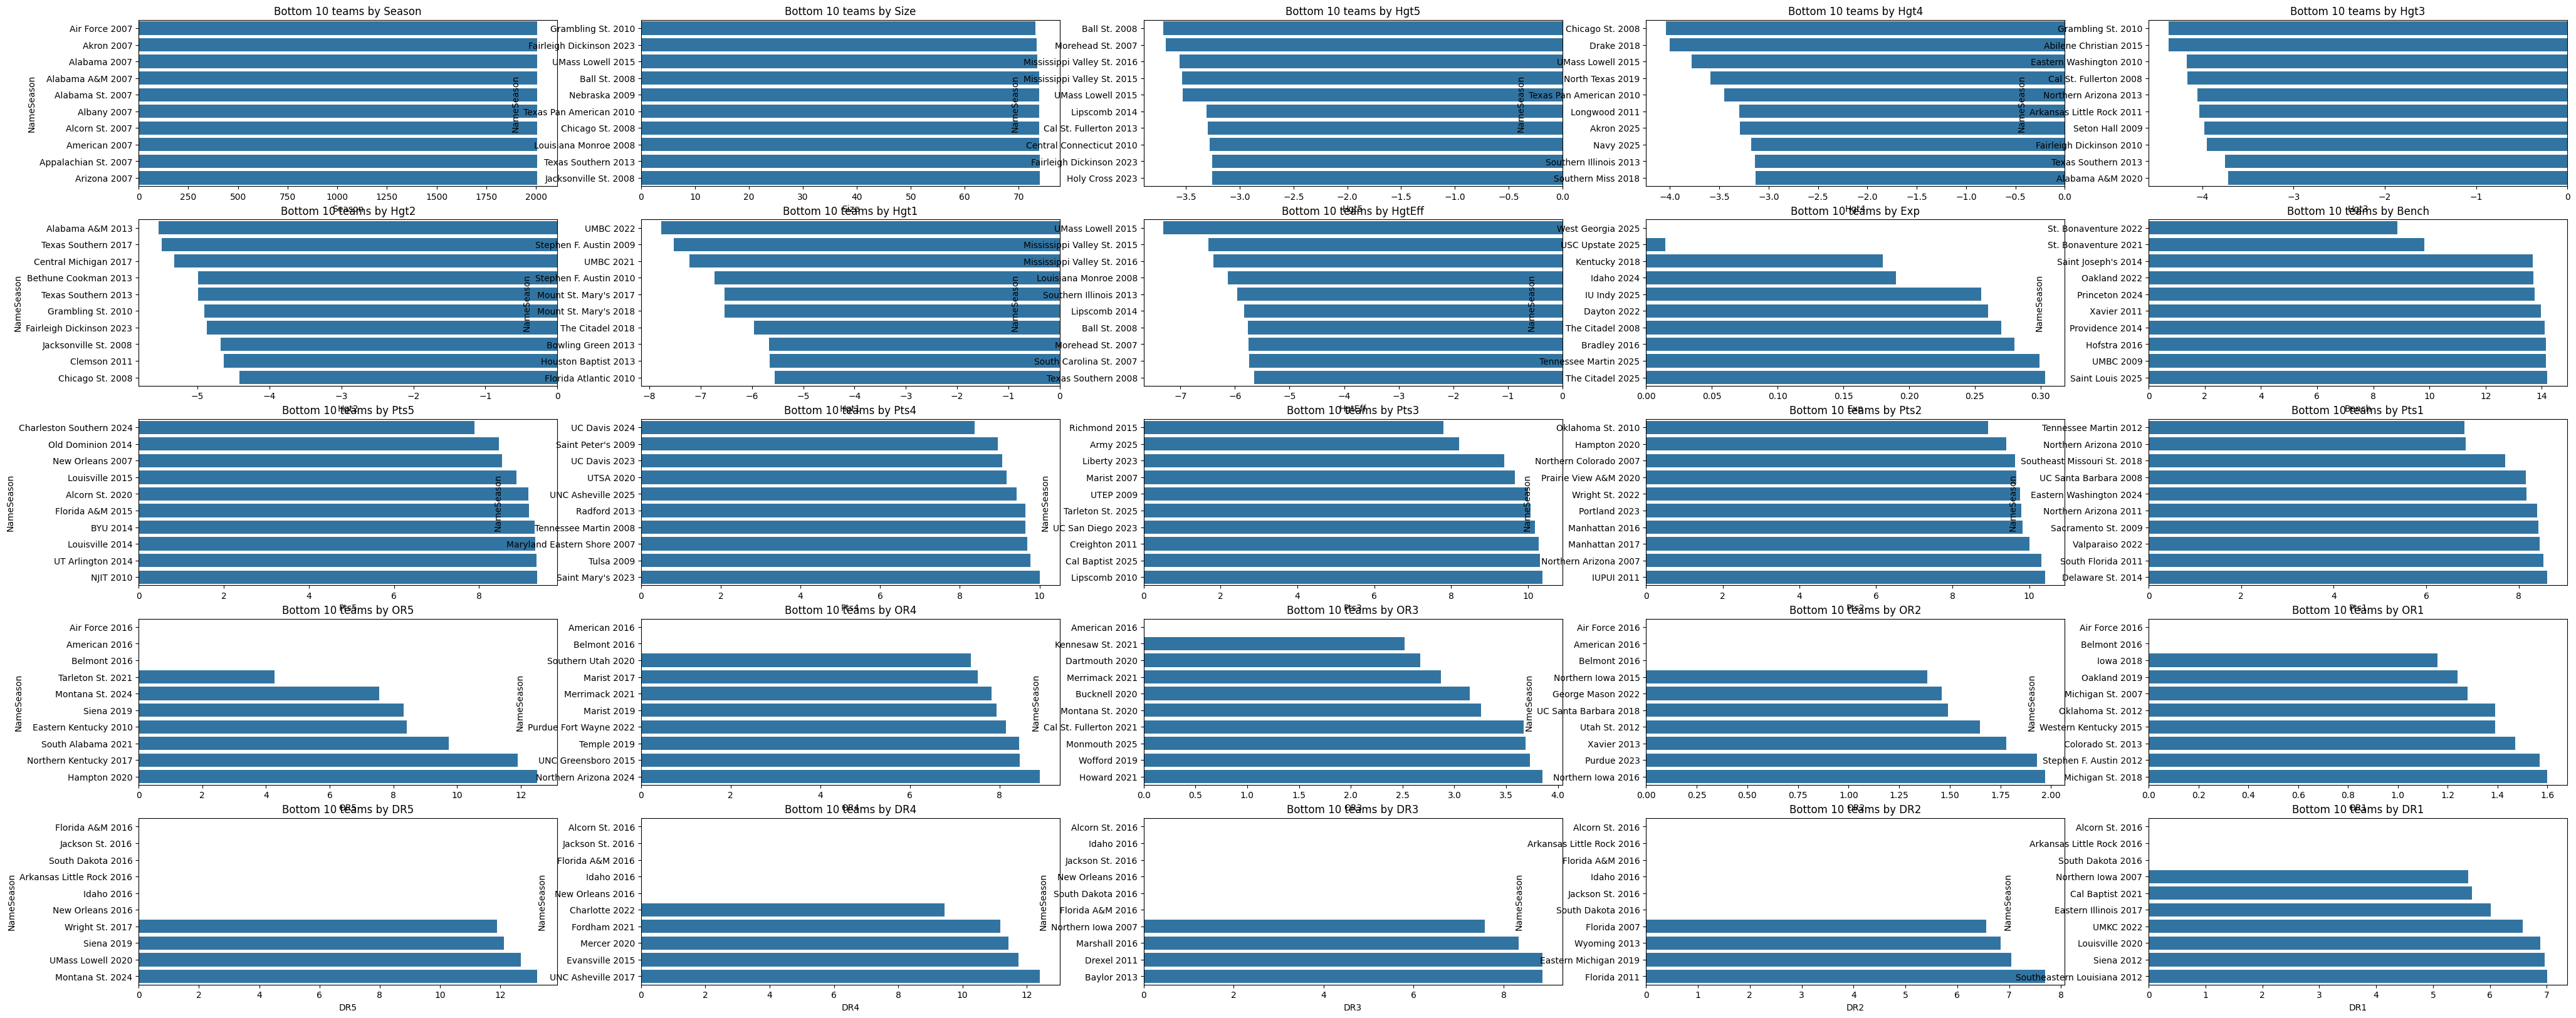

In [16]:
fig, ax=plt.subplots(nrows=5, ncols=5, figsize=(50,20))
ax=ax.flatten()
for i, col in enumerate(numerical.columns):
    top_10=demofinal.nsmallest(10, col)
    for index,row in top_10.iterrows():
        top_10.at[index, 'NameSeason']= f"{row['TeamName']} {row['Season']}"
    sns.barplot(x=top_10[col],y=top_10['NameSeason'], ax=ax[i])
    ax[i].set_title(f'Bottom 10 teams by {col}')
    ax[i].set_xlabel(f'{col}')
plt.show()

We run into the same problem as before with teams that opted out of the pandemic year.
Because those teams do not have rosters (and therefore Size values of 0.0), we can easily drop them.

In [17]:
demofinal=demofinal[demofinal['Size'] > 0.0]

In [18]:
demofinal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6660 entries, 0 to 6669
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    6660 non-null   int64  
 1   TeamName  6660 non-null   object 
 2   Size      6660 non-null   float64
 3   Hgt5      6660 non-null   float64
 4   Hgt4      6660 non-null   float64
 5   Hgt3      6660 non-null   float64
 6   Hgt2      6660 non-null   float64
 7   Hgt1      6660 non-null   float64
 8   HgtEff    6660 non-null   float64
 9   Exp       6660 non-null   float64
 10  Bench     6660 non-null   float64
 11  Pts5      6660 non-null   float64
 12  Pts4      6660 non-null   float64
 13  Pts3      6660 non-null   float64
 14  Pts2      6660 non-null   float64
 15  Pts1      6660 non-null   float64
 16  OR5       6660 non-null   float64
 17  OR4       6660 non-null   float64
 18  OR3       6660 non-null   float64
 19  OR2       6660 non-null   float64
 20  OR1       6660 non-null   float64
 

Skewness and Kurtosis of Data

In [19]:
numerical=demofinal.select_dtypes(exclude='object')
numerical.skew(axis=0, skipna=True)

Season   -0.018422
Size      0.033027
Hgt5      0.520271
Hgt4      0.023489
Hgt3      0.010508
Hgt2     -0.115315
Hgt1     -0.378268
HgtEff    0.209422
Exp      -0.055788
Bench    -0.015711
Pts5      0.315814
Pts4      0.218249
Pts3      0.201085
Pts2      0.286269
Pts1      0.399092
OR5       0.219229
OR4       0.032745
OR3       0.749121
OR2       0.910907
OR1       3.285658
DR5       0.860372
DR4       1.078922
DR3       0.433069
DR2       1.549420
DR1       7.584853
dtype: float64

In [20]:
numerical.kurtosis(axis=0,skipna=True)

Season     -1.207273
Size       -0.033450
Hgt5        0.960561
Hgt4        0.021613
Hgt3        0.196565
Hgt2        0.269914
Hgt1        0.353085
HgtEff      1.388034
Exp         0.258497
Bench      -0.021260
Pts5        0.159638
Pts4        0.071641
Pts3        0.058817
Pts2        0.157071
Pts1        0.249876
OR5         0.796253
OR4         0.273862
OR3         5.640921
OR2         1.592113
OR1        58.868051
DR5        12.264585
DR4        19.621890
DR3         2.441574
DR2        23.521751
DR1       181.920230
dtype: float64

The issues in this dataset appear to be arising from the Offensive and Defensive Rebounding columns; this may be caused by outliers, which have been appearing in the visualizations.
I may have to run IQR drops on the offending columns to correct the issue.

Correlation Analysis, broken up by relevant information clusters (experience, height, rebounding numbers)

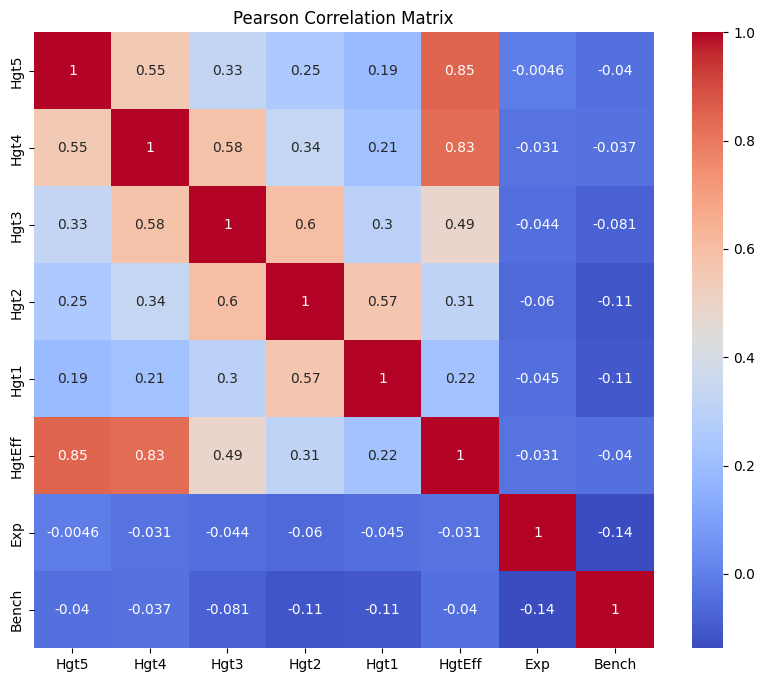

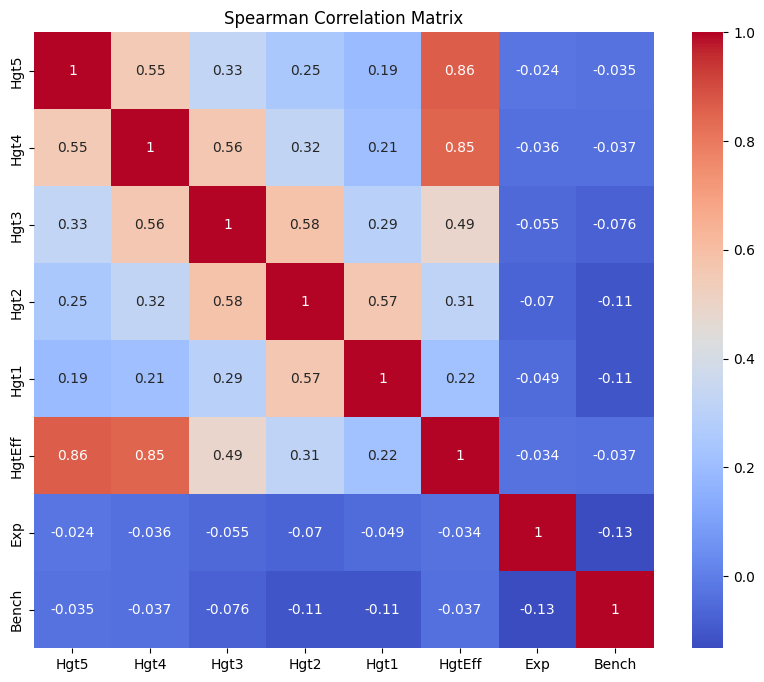

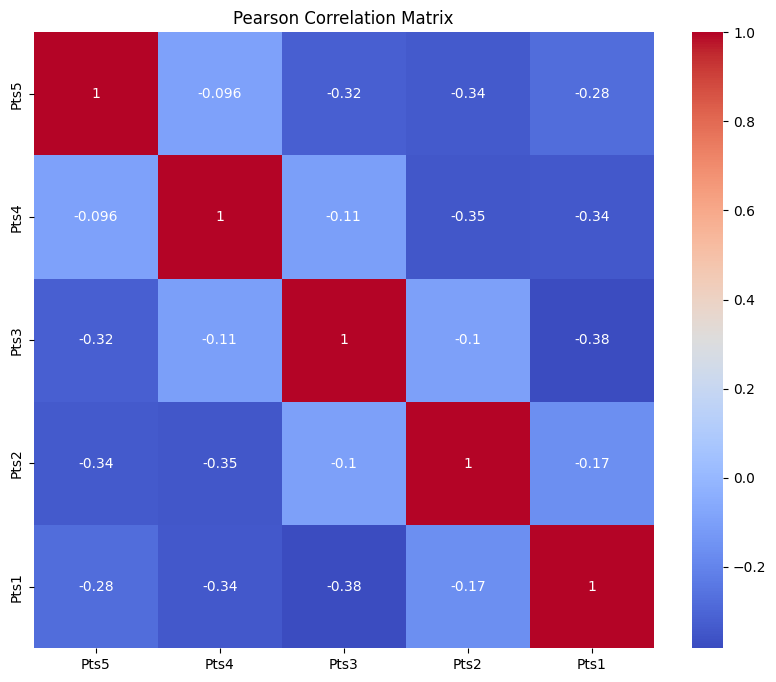

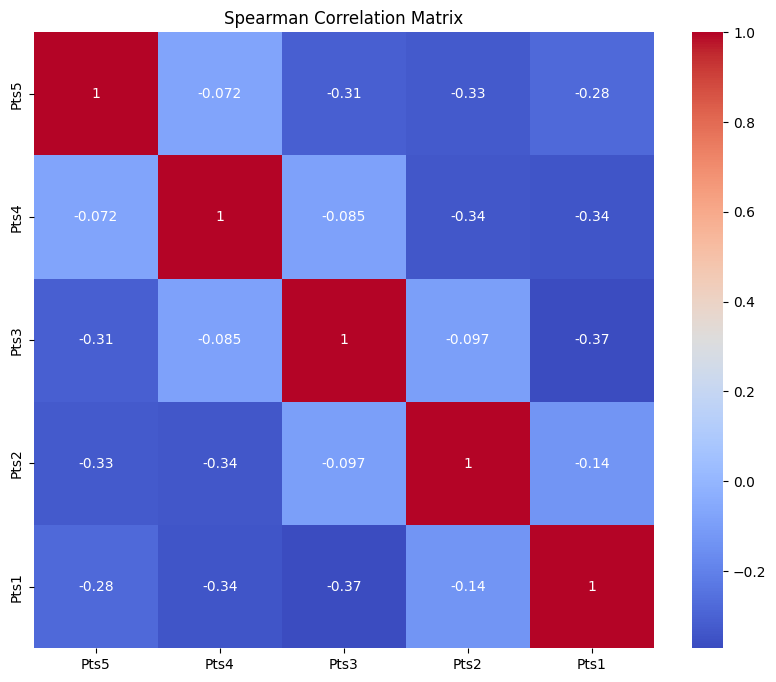

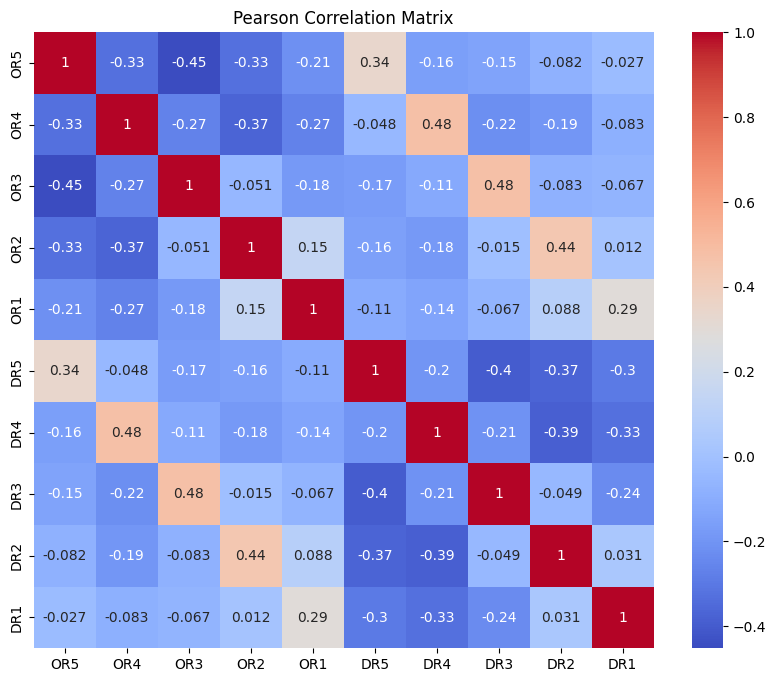

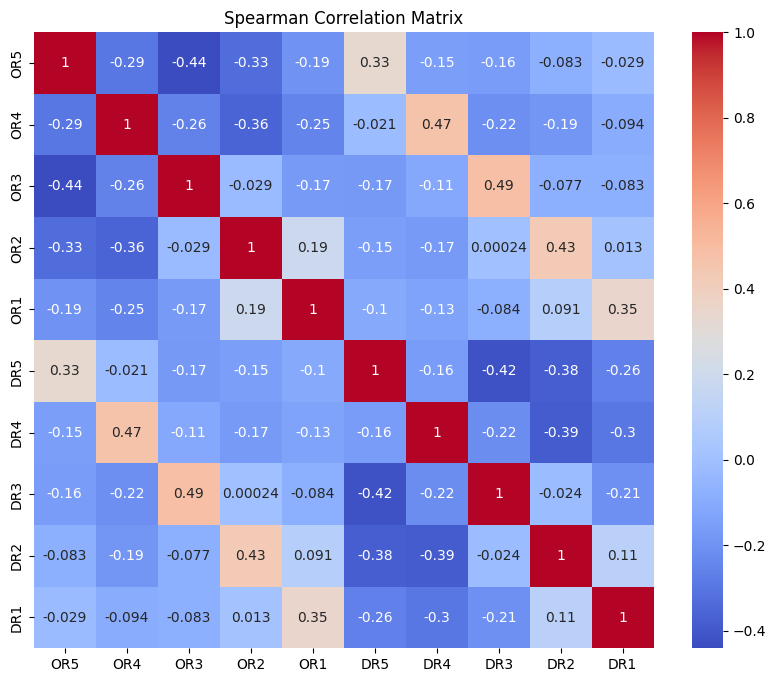

In [21]:
mask=numerical.columns.str.contains('Hgt|Exp|Bench', regex=True)
masktwo=numerical.columns.str.contains('Pts', regex=True)
maskthree=numerical.columns.str.contains('OR|DR',regex=True)
height_exp=numerical.loc[:,mask]
Pts=numerical.loc[:,masktwo]
Res=numerical.loc[:,maskthree]

for x in (height_exp,Pts,Res):
    pearson=x.corr(method='pearson')
    spearman=x.corr(method='spearman')
    plt.figure(figsize=(10,8))
    sns.heatmap(pearson, annot=True, cmap='coolwarm')
    plt.title('Pearson Correlation Matrix')
    plt.show()  

    plt.figure(figsize=(10,8))
    sns.heatmap(spearman, annot=True, cmap='coolwarm')
    plt.title('Spearman Correlation Matrix')
    plt.show()

Variance Inflation Factor for each subset of the demographic data

  features        VIF
0     Hgt5   4.648213
1     Hgt4   4.717952
2     Hgt3   2.085526
3     Hgt2   2.092208
4     Hgt1   1.486023
5   HgtEff  10.309206
6      Exp   9.512955
7    Bench   9.514172


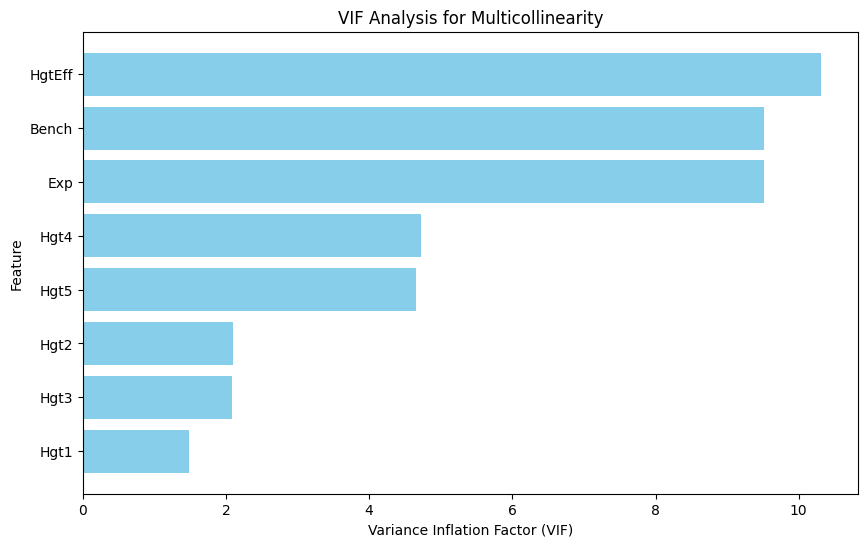

  features        VIF
0     Pts5  16.575571
1     Pts4  22.042308
2     Pts3  20.824816
3     Pts2  20.374511
4     Pts1  14.058775


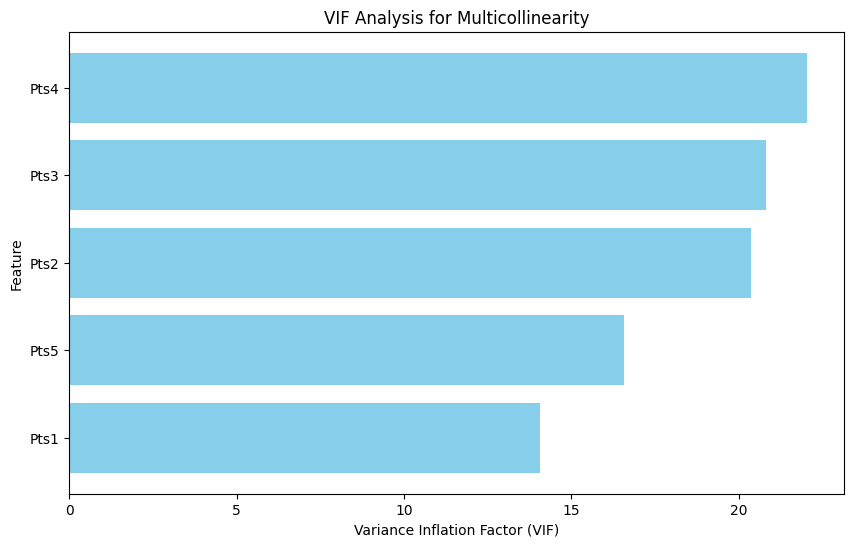

  features           VIF
0      OR5  6.848177e+06
1      OR4  4.342028e+06
2      OR3  1.881036e+06
3      OR2  8.101490e+05
4      OR1  4.476138e+05
5      DR5  3.834309e+06
6      DR4  3.196889e+06
7      DR3  2.095822e+06
8      DR2  1.461452e+06
9      DR1  1.143921e+06


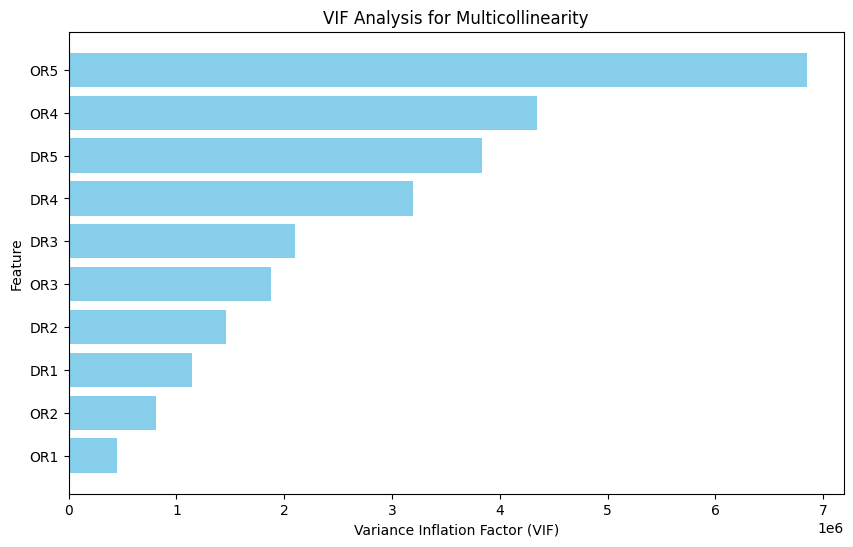

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
for x in (height_exp,Pts,Res):
    vif_data=pd.DataFrame()
    vif_data['features']=x.columns
    vif_data['VIF']=[variance_inflation_factor(x.values,i) for i in range(len(x.columns))]
    print(vif_data)

    vif_data = vif_data.sort_values(by="VIF", ascending=False)


    plt.figure(figsize=(10, 6))
    plt.barh(vif_data["features"], vif_data["VIF"], color="skyblue")
    plt.xlabel("Variance Inflation Factor (VIF)")
    plt.ylabel("Feature")
    plt.title("VIF Analysis for Multicollinearity")
    plt.gca().invert_yaxis()  
    plt.show()

Multivariate Analysis 

In [23]:
multivariatecopy=demofinal.copy(deep=True)
multivariatecopy['Team/Year']=multivariatecopy['Season'].astype(str) + ' ' +multivariatecopy['TeamName']

multivariatecopy=multivariatecopy.drop(columns=['Season','TeamName'], axis=1)

In [24]:
popper=multivariatecopy.pop('Team/Year')
multivariatecopy.insert(0,'Team/Year',popper)

In [25]:
import plotly.express as px
fig = px.scatter(
multivariatecopy,
x='HgtEff',
y='Exp',
hover_name='Team/Year',
title='relationship between effective height and average experience'
)
fig.show()

In [26]:
fig = px.scatter(
multivariatecopy,
x='HgtEff',
y='Hgt3',
hover_name='Team/Year',
title='Finding teams whose effective height are most closely tied to the heights of their small forwards'
)
fig.show()